In [1]:
import sys
sys.path.append('C:\\Users\\Gabriel\\GitHub\\bloqueios')
import newBlock as nb
import pandas as pd
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import metpy.calc as mpcalc
import calendar

In [2]:
vento = xr.open_dataset("D:\\_Gabriel\\Estudo\\UFF\\Bloqueios_Atmosfericos\\Climatologias\\nc\\ver_inv_850hPa.nc")

In [3]:
vento

<xarray.Dataset>
Dimensions:    (latitude: 61, longitude: 81, time: 29160)
Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 -10.0 -10.25 -10.5 ... -24.5 -24.75 -25.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-06-22 17:55:35 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [4]:
dayly = vento.resample(time="D", keep_attrs=True).mean()

In [5]:
dayly.u.attrs.update({'units': 'm s**-1', 'long_name': 'U component of wind', 'standard_name': 'eastward_wind'})
dayly.v.attrs.update({'units': 'm s**-1', 'long_name': 'V component of wind', 'standard_name': 'northward_wind'})
dayly_obj = nb.lammoc_dataset(dayly, 'ERA-5')

In [6]:
climat_div = dayly_obj.formatar(lon = [-60, -40], opr='divergência', time = ['1979-01-01', '2010-12-01'])

In [7]:
climat_vort = dayly_obj.formatar(lon = [-60, -40], opr='vorticidade', time = ['1979-01-01', '2010-12-01'])

In [11]:
ind = blockix([climat_vort, climat_div], bloq='continuo', freq='D')

C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
ind['time'] = ind.time.dt.month

In [13]:
jan_dez = xr.concat([ind.sel(time=1),ind.sel(time=12)], dim='time')

In [23]:
climat = jan_dez.groupby('time').mean()

In [15]:
lev_div = dayly_obj.formatar(lon = [-60, -40], opr='divergência', time = ['2010-01-01', '2018-12-01'])

In [16]:
lev_vort = dayly_obj.formatar(lon = [-60, -40], opr='vorticidade', time = ['2010-01-01', '2018-12-01'])

In [17]:
lev_ind = blockix([lev_vort, lev_div], bloq='continuo', freq='D')
lev_ind['time'] = lev_ind.time.dt.month
lev_jan_dez = xr.concat([lev_ind.sel(time=1),lev_ind.sel(time=12)], dim='time')
lev = lev_jan_dez.groupby('time').mean()

C:\Users\Gabriel\miniconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [24]:
climat

<xarray.Dataset>
Dimensions:              (time: 2)
Coordinates:
  * time                 (time) int64 1 12
Data variables:
    índice de bloqueios  (time) float64 0.4314 0.3689

In [25]:
lev

<xarray.Dataset>
Dimensions:              (time: 2)
Coordinates:
  * time                 (time) int64 1 12
Data variables:
    índice de bloqueios  (time) float64 0.1579 0.3226

In [19]:
anom = lev - climat
anom

<xarray.Dataset>
Dimensions:              (time: 2)
Coordinates:
  * time                 (time) int64 1 12
Data variables:
    índice de bloqueios  (time) float64 -0.2735 -0.04635

In [26]:
ind

<xarray.Dataset>
Dimensions:              (time: 11658)
Coordinates:
  * time                 (time) int64 1 1 1 1 1 1 1 1 ... 11 11 11 11 11 11 12
Data variables:
    índice de bloqueios  (time) float64 nan nan nan nan nan ... nan nan nan nan

In [27]:
lev_ind

<xarray.Dataset>
Dimensions:              (time: 3257)
Coordinates:
  * time                 (time) int64 1 1 1 1 1 1 1 1 ... 11 11 11 11 11 11 12
Data variables:
    índice de bloqueios  (time) float64 nan nan nan 0.0 0.0 ... nan nan nan nan

In [40]:
climat_ind = nb.lammoc_medias(jan_dez,'ERA-5').climatologia()
jan_dez = climat_ind.dataset.sel(month=[1,12])
jan_dez

AttributeError: 'IndexVariable' object has no attribute 'month'

CORRELAÇÕES PARA 850 hPA


In [9]:
def posix(datasets, bloq = 'continuo', freq='D'):

    da = []
    
    if type(datasets) != list:
        datasets = [datasets]
        
    for ds in datasets:
        
        start = pd.to_datetime(ds.dataset.time.values[0])
        end = pd.to_datetime(ds.dataset.time.values[-1])
        latitudes = [ds.dataset.lat.values[0], ds.dataset.lat.values[-1]]
        longitudes = [ds.dataset.lon.values[0], ds.dataset.lon.values[-1]]
        
        ext_name = ds.dataset.to_array().isel(variable=0)
        var = str(ext_name['variable'].values)
    
        med = ds.media_regional()
        dropped = med.dataset.where(med.dataset[var]>0, drop=True)
        bloqueio = 0 
        bloqueios = {} 

        for ix, dia in enumerate(pd.to_datetime(dropped.time.values)):
            aux = dropped.sel(time=dia)
            if ix == 0:
                count = 1
                bloqueio = 0
                bloqueios.update({dia: bloqueio})
            else:
                if (dia == pd.to_datetime(dropped.time.values[ix-1]) + datetime.timedelta(days = 1)) and (dia.day != 1):
                    count += 1
                    if count >= 3:
                        bloqueio += 1
#                         bloqueios.update({dia: bloqueio})
                    if bloq == 'total':
                        bloqueios.update({dia - datetime.timedelta(days = 1): 0})
                        bloqueios.update({dia: bloqueio})
                    else:
                        bloqueios.update({dia: bloqueio})
                else:
                    count = 1
                    bloqueio = 0
                    bloqueios.update({dia: bloqueio})
                    
        da.append(xr.DataArray(list(bloqueios.values()), coords=[list(bloqueios.keys())], dims=['time'], name=var))
        
    ds = xr.merge(da)
    ds = ds.reindex({"time": pd.date_range(start=start, end=end, freq='D')})
#     ds = ds.fillna(0, inplace=True)
#     ds = ds.dropna('time', 'any')

    if freq == 'D':
        ds.attrs['lat'] = str(latitudes[0]) + " : " + str(latitudes[1])
        ds.attrs['lon'] = str(longitudes[0]) + " : " + str(longitudes[1])
        return ds
    
    elif freq == 'M' and bloq == 'total':
        ds = ds.resample(time='MS').sum()
#         ds = ds.dropna('time', 'any')
        ds.attrs['lat'] = str(latitudes[0]) + " : " + str(latitudes[1])
        ds.attrs['lon'] = str(longitudes[0]) + " : " + str(longitudes[1])
        return ds
    
    elif freq == 'season' and bloq == 'total':
        ds = ds.resample(time='QS-DEC').sum()
#         ds = ds.dropna('time', 'any')
        ds.attrs['lat'] = str(latitudes[0]) + " : " + str(latitudes[1])
        ds.attrs['lon'] = str(longitudes[0]) + " : " + str(longitudes[1])
        return ds

In [10]:
def blockix(ds, bloq='continuo', freq='D'):
    
    bloqueios = {}
    positivos = posix([ds[0], ds[1]])
    datas = positivos.dropna('time', 'any')
    count = 0
    
    for ix, dia in enumerate(pd.to_datetime(datas.time.values)):
        
        if ix == 0:
            if datas.div.sel(time=dia) != 0 and datas.vort.sel(time=dia) != 0:
                count += 1
            else: 
                count = 0
            bloqueios.update({dia: count})

        if (dia == pd.to_datetime(datas.time.values[ix-1]) + datetime.timedelta(days = 1)) and (dia.day != 1):
            if datas.div.sel(time=dia) != 0 and datas.vort.sel(time=dia) != 0:
                count += 1
    #                 bloqueios.update({dia: count})

                if bloq == 'total':
                    bloqueios.update({dia - datetime.timedelta(days = 1): 0})
                    bloqueios.update({dia: count})

                elif bloq == 'continuo':
    #                 bloqueios.update({dia - datetime.timedelta(days = 1): count-1})
                    bloqueios.update({dia: count})

            else:
                count = 0
                bloqueios.update({dia: count})    

        else:
            count = 0
            if datas.div.sel(time=dia) != 0 and datas.vort.sel(time=dia) != 0:
                count += 1
            bloqueios.update({dia: count})
    #         count = 1

    indice = xr.DataArray(list(bloqueios.values()), coords=[list(bloqueios.keys())], dims=['time'], name='índice de bloqueios')
    indice = indice.reindex({"time": pd.date_range(start=positivos.time.values[0], end=positivos.time.values[-1], freq='D')})
    indice = indice.to_dataset()
    # indice

    if freq == 'D':
        indice = indice
        return indice
        
    elif freq == 'M' and bloq == 'total':
        indice = indice.resample(time='MS').sum()
    #     indice = indice.dropna('time', 'any')
        return indice

    elif freq == 'season' and bloq == 'total':
        indice = indice.resample(time='QS-DEC').sum()
        return indice

    

In [24]:
def vazoes(regiao = 'todas'):
    
    vazoes = pd.read_csv("Índices/vazoesdiarias.csv", sep=";", header=5, index_col=0, decimal = ',', low_memory=False)
    vazoes.index = pd.to_datetime(vazoes.index, errors='coerce')
    
    vazoes_br = vazoes.loc['1979-01-01' : '2019-01-01', ['246', '34', '237', '240', '33', '24', '6', '18', '156', '168', '275', '287', '285', '190', '254']]
    vazoes_br = vazoes_br.apply(pd.to_numeric, errors='ignore')
    
    vazoes_sul = vazoes.loc['1979-01-01' : '2019-01-01', ['111', '217', '74', '78', '66', '63', '61']]
    vazoes_sul = vazoes_sul.apply(pd.to_numeric, errors='ignore')
    
    br = xr.Dataset.from_dataframe(vazoes_br)
    br = br.rename({'index': 'time'})
    br = br.sortby('time')
    
    sul = xr.Dataset.from_dataframe(vazoes_sul)
    sul = sul.rename({'index': 'time'})
    sul = sul.sortby('time')
    
    if regiao == 'todas':
        return [br, sul]
    
    elif regiao == 'sul':
        return sul
    
    elif regiao == 'br':
        return br

In [25]:
def normalizar(ds):
    
    minimum = []
    maximum = []
    
    for index in ds.data_vars:
        minimum.append(ds.data_vars[index].values.min())
        maximum.append(ds.data_vars[index].values.max())
        datamin = np.min(minimum)
        datamax = np.max(maximum)
        
    norm = (ds-datamin)/(datamax-datamin)
    
    return norm

In [26]:
def vazcorrs(atmds, regiao, groupby='season', bloq='total', freq='season', season=None, mes=None, savefig=False, save_csv=False):
    
    # ATMDS --> DADOS DE DIV E VORT
    # REGIAO --> 'SUL' OU 'BR'
    # GROUPBY --> 'SEASON' PARA ANÁLISE SAZONAL E 'MONTH' PARA ANÁLISE MENSAL
    # BLOQ --> PARA CORRELAÇÕES USAREMOS SOMENTE BLOQ = 'TOTAL' (POR ENQUANTO) --> NÚMERO TOTAL DE BLOQUEIOS E DE INDICES DE VORT E DIV
    # FREQ --> 'SEASON' (SOMENTE SE 'GROUPBY = SEASON') E 'M' (SOMENTE SE 'GROUPBY = MONTH')
    # SEASON --> ESPECIFICAÇÃO DA ESTAÇÃO DO ANO (SOMENTE SE 'GROUPBY' E 'FREQ' = 'SEASON')
    # MES --> ESPECIFICAÇÃO DO MÊS DE ANÁLISE (SOMENTE SE 'GROUPBY = MONTH' E 'FREQ = M')
    # SAVEFIG --> SALVA A FIGURA
    # SAVE_CSV --> SALVA O DATAFRAME.CSV
    
    indice_bloq = blockix([atmds[0], atmds[1]], bloq, freq)
    indice_div_vort = posix([atmds[0], atmds[1]], bloq, freq)
    
    # NOMEANDO O BLOQUEIO EM FUNÇÃO DE SUAS LATITUDES (BLOQUEIO NORTE, SUL, COMPLETO)
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-10.0_-25.0':
        bloq_name = "Completo"
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-10.0_-17.5':
        bloq_name = "BloqueioNorte"
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-17.5_-25.0':
        bloq_name = "BloqueioSul"    
    
    # FORMATANDO O DATASET DE VAZÕES PARA MESMO INTERVALO TEMPORAL DO DATASET DE INDICES_BLOQ / INDICES_DIV_VORT
    vaz = vazoes(regiao=regiao).sel(time=slice(pd.to_datetime(indice_bloq.time.values[0]), pd.to_datetime(indice_bloq.time.values[-1])))
    
    if groupby == 'season':
        normvaz = normalizar(vaz.resample(time='QS-DEC').mean()).to_dataframe()
    elif groupby == 'month':
        normvaz = normalizar(vaz.resample(time='MS').mean()).to_dataframe()
    
    # JUNTANDO OS 3 DATASETS E FORMATANDO EM DATAFRAME (TIRAR A CORRELAÇÃO E MELHOR VISUALIZAÇÃO)
    df = normvaz.join([indice_bloq.to_dataframe(), indice_div_vort.to_dataframe()])
    df.fillna(0, inplace=True)
    corre = df.corr()
    
    # CORRELAÇÃO SOMENTE DOS INDÍCES COM AS BACIAS SUL
    if regiao == "sul":
        corre.drop(["111", "217", "74", "78", "66", "63", "61"], axis=0, inplace=True)
        corre.drop(["índice de bloqueios", "div", "vort"], axis=1, inplace=True)
        
    # CORRELAÇÃO SOMENTE DOS INDÍCES COM AS BACIAS BR  
    elif regiao == "br":
        corre.drop(["246", "34", "237", "240", "33", "24", "6", "18", "156", "168", "275", "287", "285", "190", "254"], axis=0, inplace=True)
        corre.drop(["índice de bloqueios", "div", "vort"], axis=1, inplace=True)
    
    if groupby == 'season':
        if season == "DJF":
            df = df[df.index.month==12]
        if season == "MAM":
            df = df[df.index.month==3]
        if season == "JJA":
            df = df[df.index.month==6]
        if season == "SON":
            df = df[df.index.month==9]
            
    elif groupby == 'month':
        df = df[df.index.month==mes]
        
    corr = plt.figure(figsize=(12,5))
#     mask = np.triu(np.ones_like(corre, dtype=np.bool))
    
    # IDENTIFICAÇÃO DAS BACIAS POR SEUS NOMES E NÃO POR SEUS CÓDIGOS
    sul_x_labels = ['Passo Real', 'Machadinho', 'Foz do Areia', 'Salto Osório', 'Itaipu', 'Rosana', 'Capivara']
    sul_y_labels = ['Índices de Bloqueio', 'Divergência', 'Vorticidade']
    br_x_labels = ['Porto Primavera', 'Ilha Solteira', 'Barra Bonita', 'Promissão', 'São Simão', 'Emborcação', 'Furnas', 'Água Vermelha', 'Três Marias', 'Sobradinho Inc', 'Tucuruí', 'Santo Antônio', 'Jirau', 'Boa Esperança', 'Pedra do Cavalo']
    br_y_labels = ['Índices de Bloqueio', 'Divergência', 'Vorticidade']

    # PLOTANDO O HEATMAP E ATRIBUINDO AS FORMATAÇÕES E 'DESIGN' NECESSÁRIOS
    if regiao == 'sul':
        corr = plt.figure(figsize=(12,5))
        corr = sns.heatmap(corre, annot=True, annot_kws={'fontsize':12, 'weight': 'bold'}, cbar_kws={'pad': 0.02}, cmap='RdBu', vmin=-1, vmax=1, center = 0, xticklabels=sul_x_labels, yticklabels=sul_y_labels)
        plt.yticks(rotation=0)
        
    # PLOTANDO O HEATMAP E ATRIBUINDO AS FORMATAÇÕES E 'DESIGN' NECESSÁRIOS
    elif regiao == 'br':
        corr = plt.figure(figsize=(33.5,8))
        corr = sns.heatmap(corre, annot=True, annot_kws={'fontsize':15, 'weight': 'bold'}, cbar_kws={'pad': 0.02}, cmap='RdBu', vmin=-1, vmax=1, center = 0, xticklabels=br_x_labels, yticklabels=br_y_labels)
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=15)
        
    # ESPECIFICAÇÕES DE TÍTULO DA FIGURA E DOS NOMES DAS IMAGENS E/OU ARQUIVOS.CSV EXPORTADOS
    if groupby == 'season':
        if regiao == 'sul':
            corr.set_title('Correlações (' + indice_div_vort.attrs['lat'] + ' | ' + indice_div_vort.attrs['lon'] + ' | 850 hPa) x Bacias: ' + regiao.upper() + ' (' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '-' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' : ' + season + ')', fontsize=10)
        else:
            corr.set_title('Correlações (' + indice_div_vort.attrs['lat'] + ' | ' + indice_div_vort.attrs['lon'] + ' | 850 hPa) x Bacias: ' + regiao.upper() + ' (' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '-' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' : ' + season + ')', fontsize=20)
        if savefig == True:
            plt.savefig('corr_850_' + bloq_name + '_' + regiao.upper() + '_' + season + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.png', format='png')
        if save_csv == True:
            df.to_csv('corr_850_' + bloq_name + '_' + regiao.upper() + '_' + season + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.csv')
            
    # ESPECIFICAÇÕES DE TÍTULO DA FIGURA E DOS NOMES DAS IMAGENS E/OU ARQUIVOS.CSV EXPORTADOS
    elif groupby == 'month':
        if regiao == 'sul':
            corr.set_title('Correlações (' + indice_div_vort.attrs['lat'] + ' | ' + indice_div_vort.attrs['lon'] + ' | 850 hPa) x Bacias: ' + regiao.upper() + ' (' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '-' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' : ' + calendar.month_abbr[mes].upper() + ')', fontsize=10)
        else:
            corr.set_title('Correlações (' + indice_div_vort.attrs['lat'] + ' | ' + indice_div_vort.attrs['lon'] + ' | 850 hPa) x Bacias: ' + regiao.upper() + ' (' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '-' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' : ' + calendar.month_abbr[mes].upper() + ')', fontsize=20)
        if savefig == True:
            plt.savefig('corr_850_' + bloq_name + '_' + regiao.upper() + '_' + calendar.month_abbr[mes].upper() + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.png', format='png')
        if save_csv == True:   
            df.to_csv('corr_850_' + bloq_name + '_' + regiao.upper() + '_' + calendar.month_abbr[mes].upper() + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.csv')


CORRELAÇÕES DA BACIA DO SUL (SOMENTE) PARA INVERNO

C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype

<Figure size 864x360 with 0 Axes>

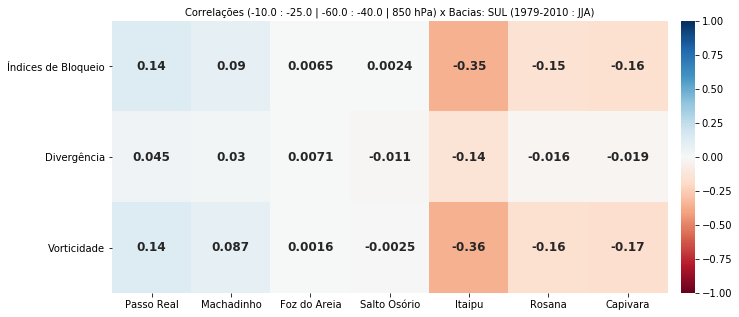

<Figure size 864x360 with 0 Axes>

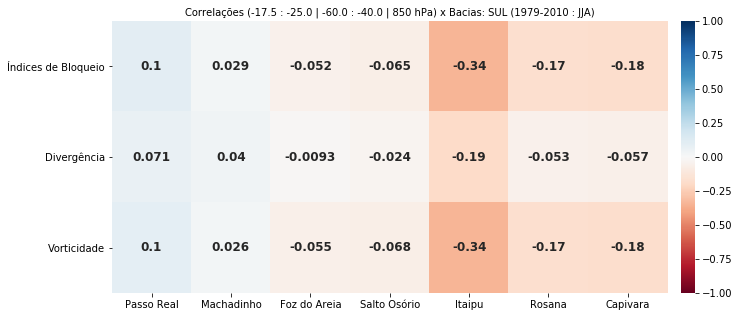

<Figure size 864x360 with 0 Axes>

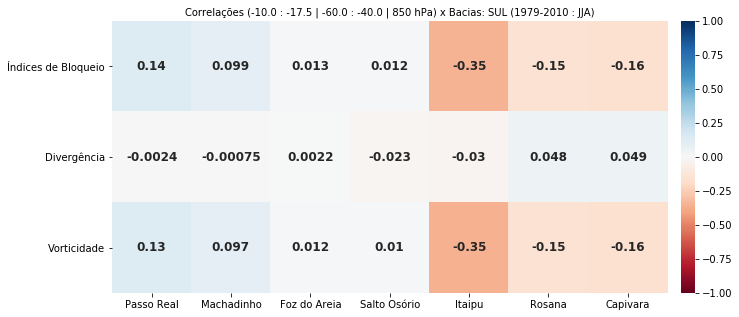

<Figure size 864x360 with 0 Axes>

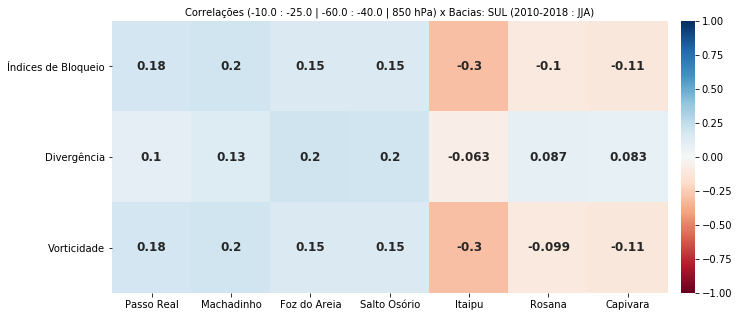

<Figure size 864x360 with 0 Axes>

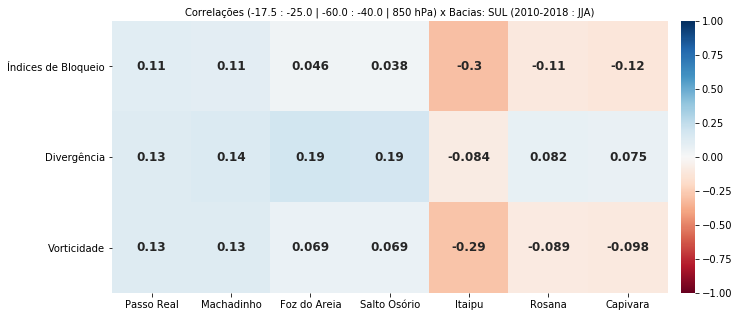

<Figure size 864x360 with 0 Axes>

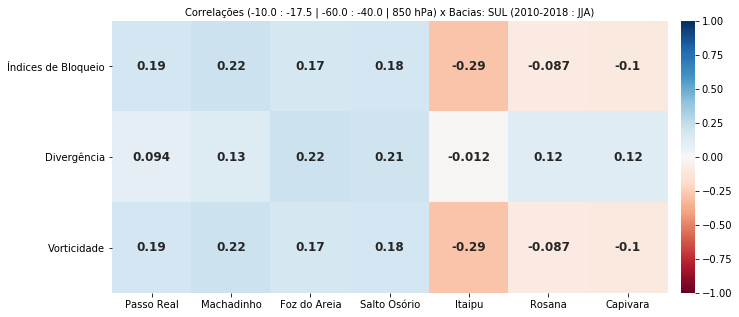

In [43]:
seasons = ['JJA']
regioes = ['sul']
periodos = [['1979-01-01', '2010-12-31'], ['2010-01-01', '2018-12-31']]
latitudes = [[-10, -25], [-17.5, -25], [-10,-17.5]]
for periodo in periodos:
    for latitude in latitudes:
        div = dayly_obj.formatar(lat = latitude, lon = [-60, -40], time = periodo, level=850, opr='divergência')
        vort = dayly_obj.formatar(lat = latitude, lon = [-60, -40], time = periodo, level=850, opr='vorticidade')
        for regiao in regioes:
            for season in seasons:
                df = vazcorrs(atmds=[vort, div], regiao=regiao, groupby='season', bloq='total', freq='season', season=season, mes=None, savefig=True, save_csv=True)

C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\augus\Anaconda3\envs\bloqueios\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype

<Figure size 864x360 with 0 Axes>

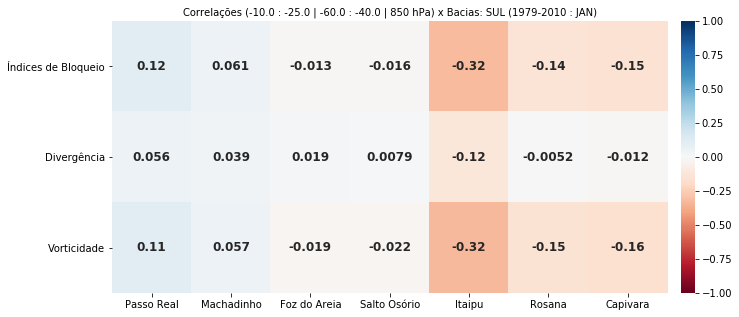

<Figure size 864x360 with 0 Axes>

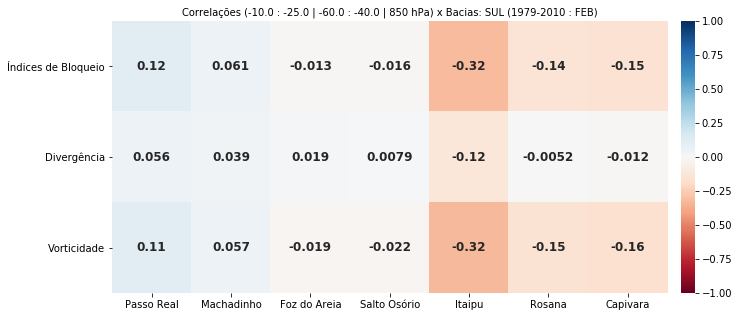

<Figure size 864x360 with 0 Axes>

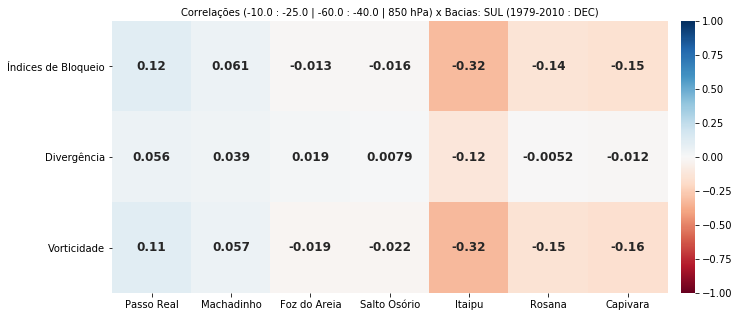

<Figure size 864x360 with 0 Axes>

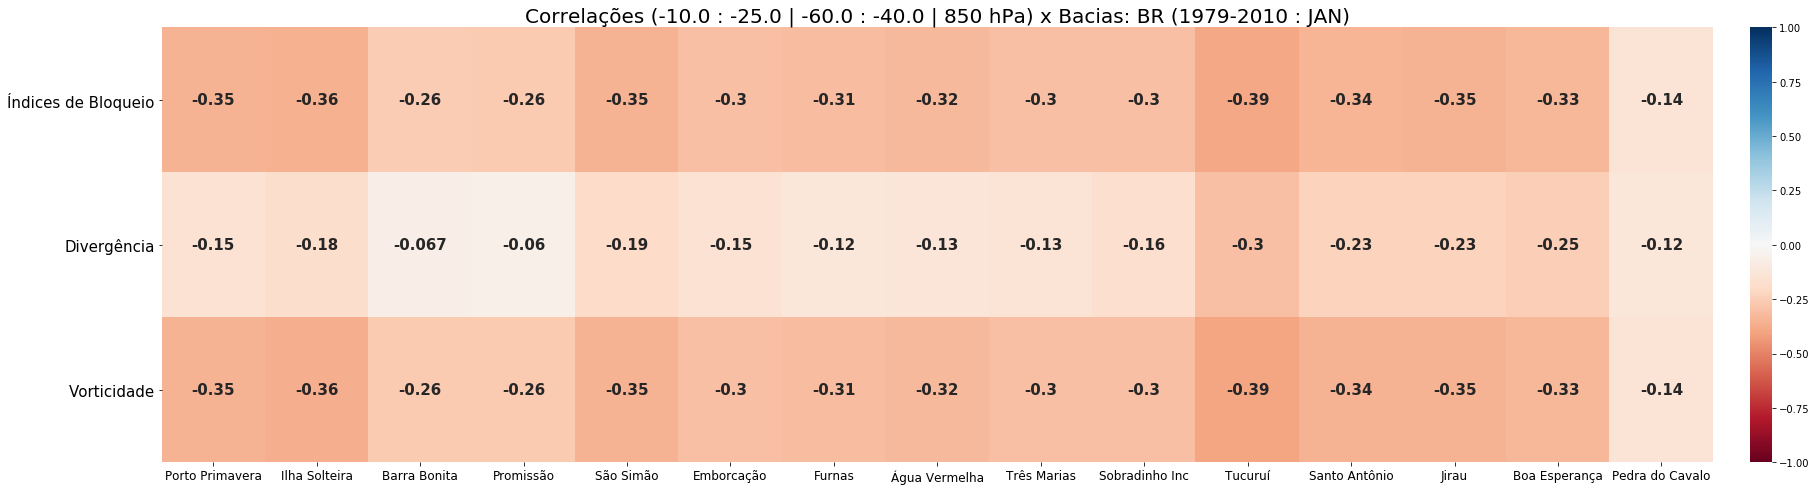

<Figure size 864x360 with 0 Axes>

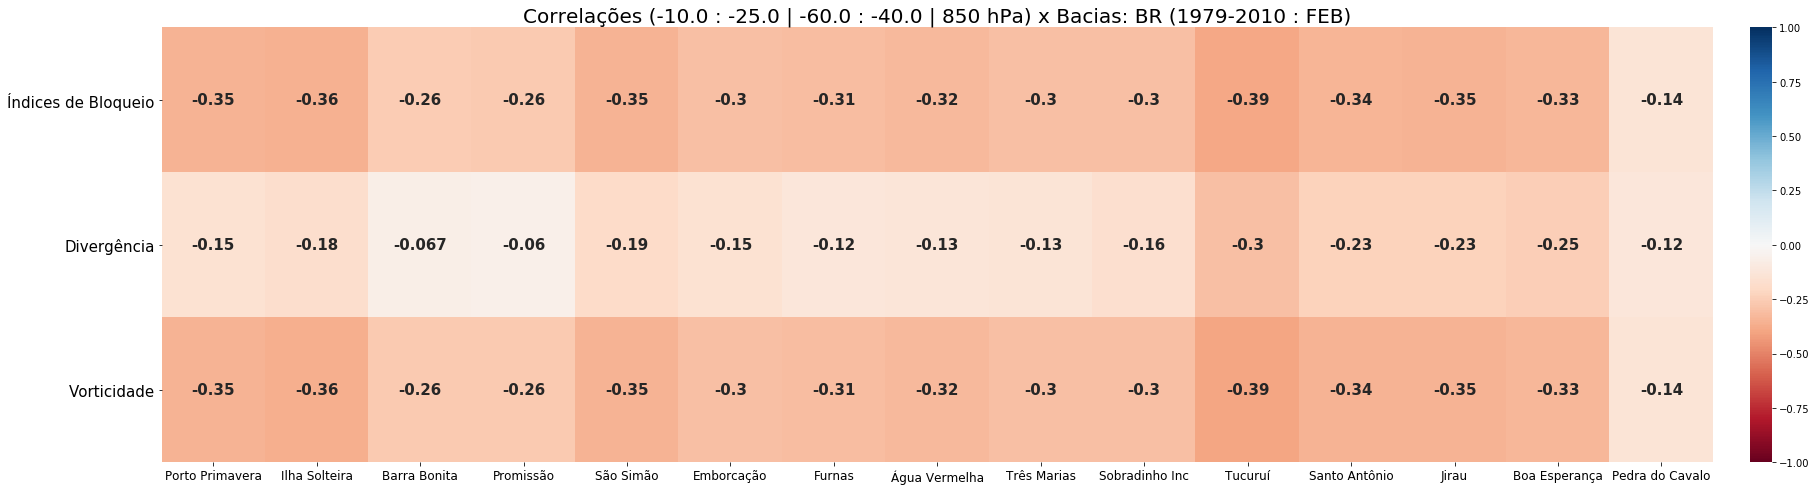

<Figure size 864x360 with 0 Axes>

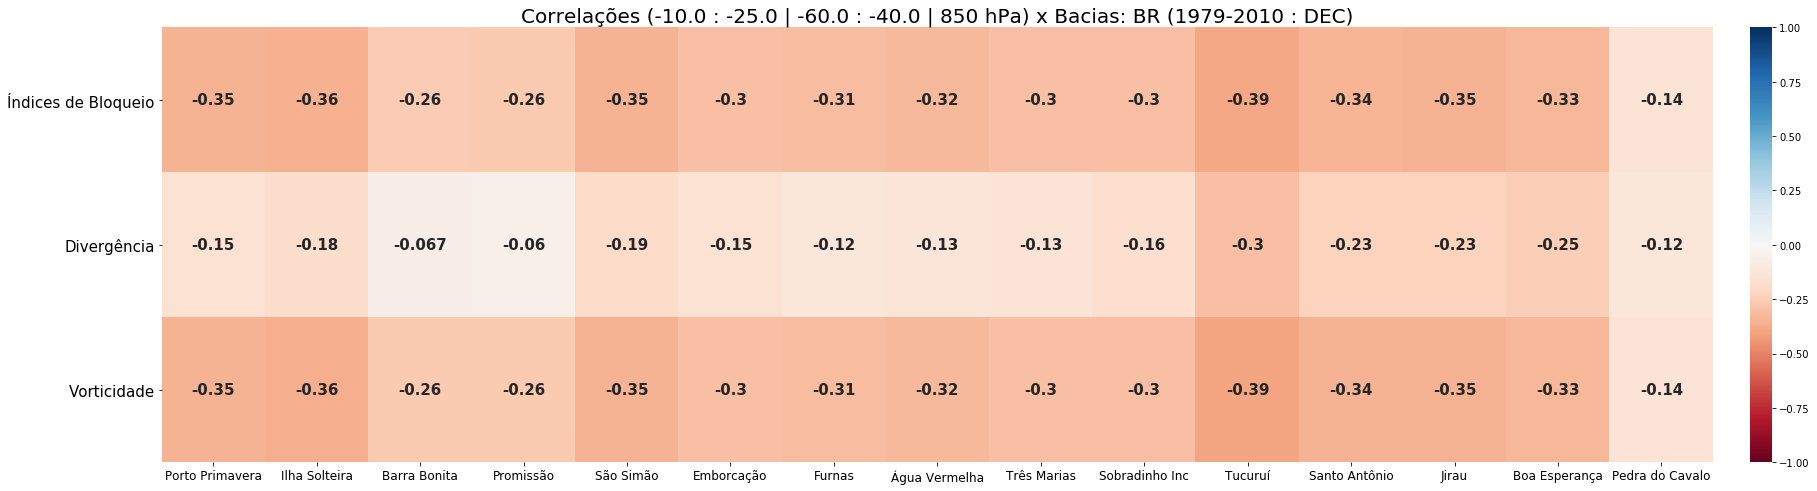

<Figure size 864x360 with 0 Axes>

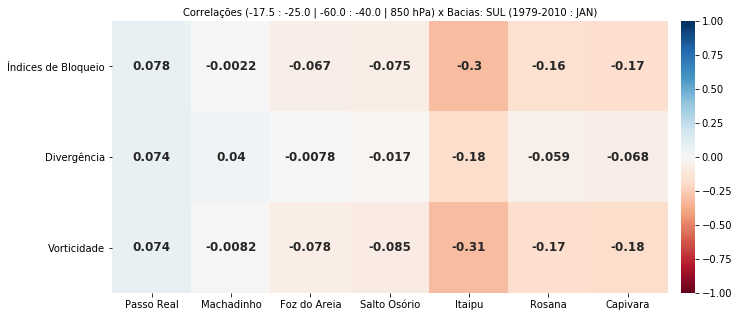

<Figure size 864x360 with 0 Axes>

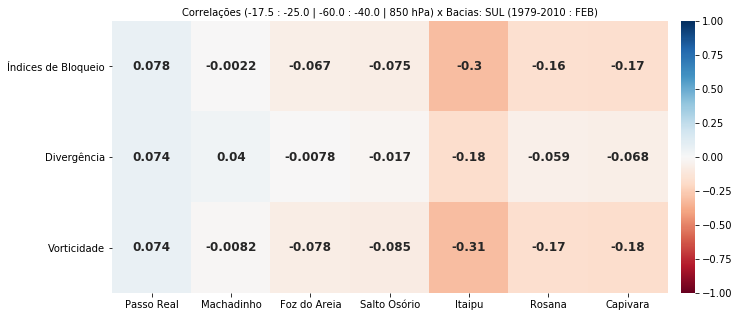

<Figure size 864x360 with 0 Axes>

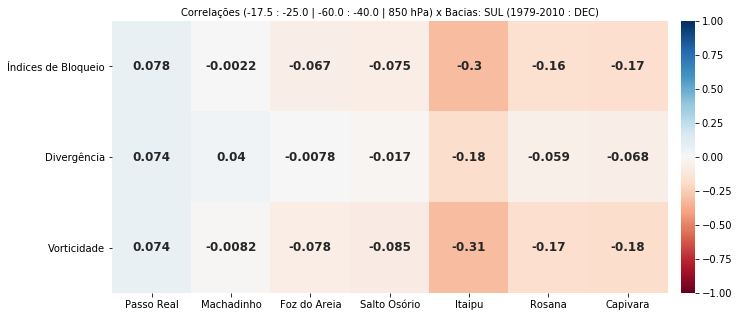

<Figure size 864x360 with 0 Axes>

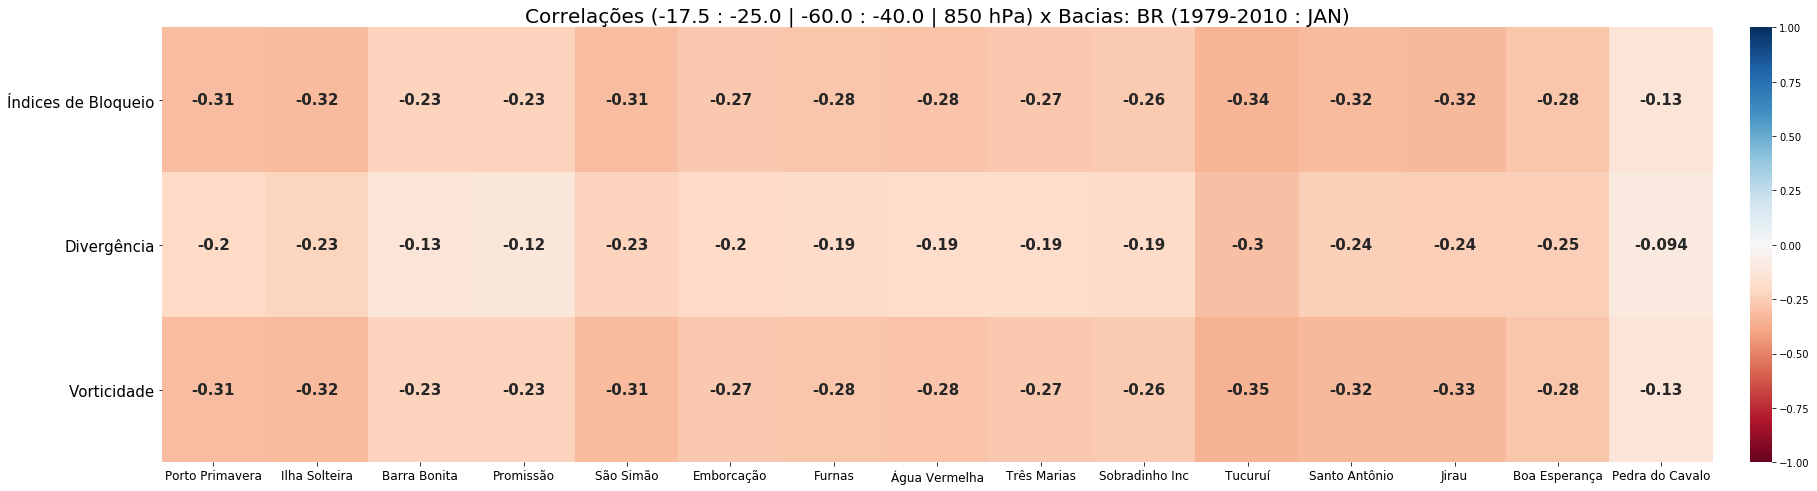

<Figure size 864x360 with 0 Axes>

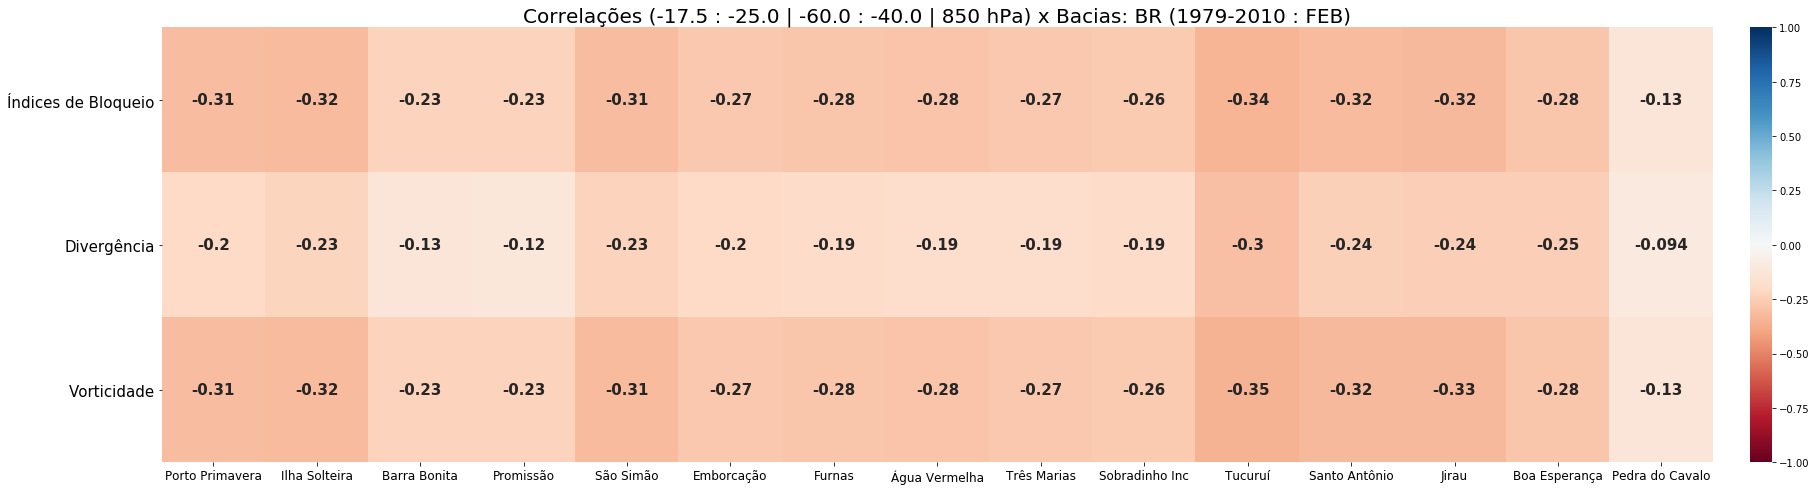

<Figure size 864x360 with 0 Axes>

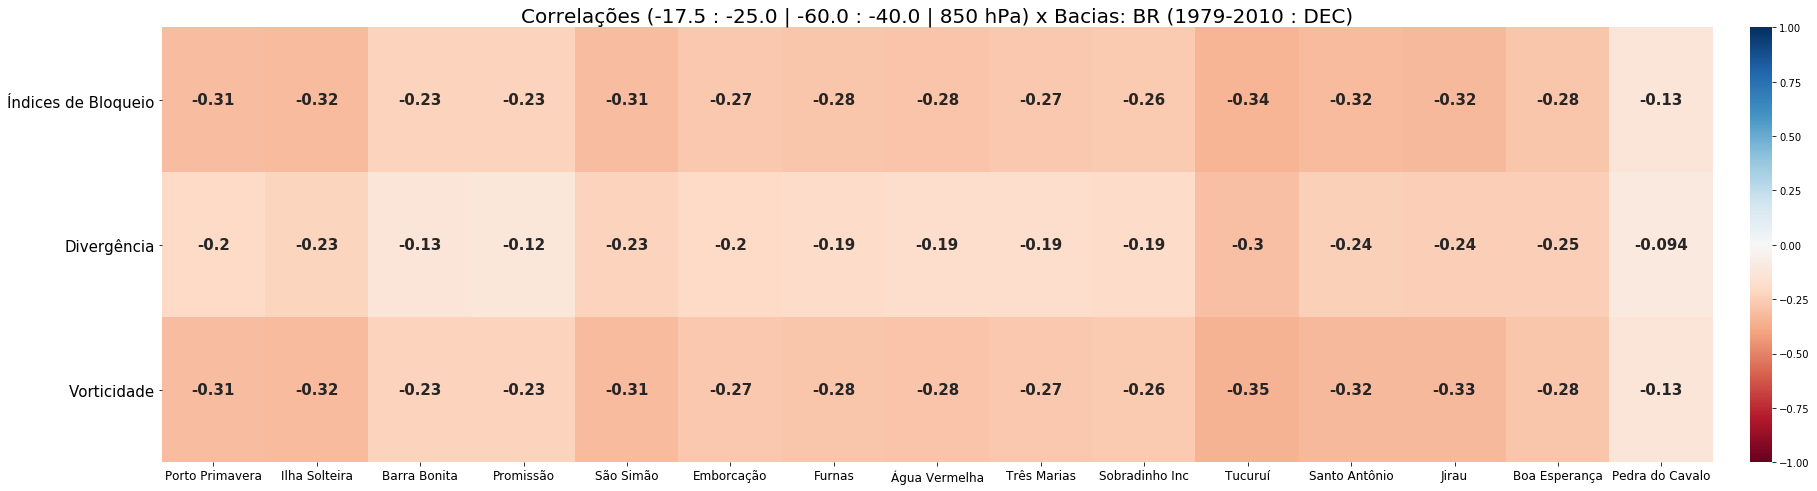

<Figure size 864x360 with 0 Axes>

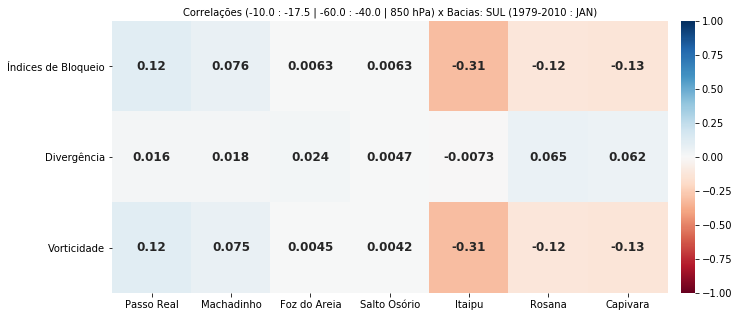

<Figure size 864x360 with 0 Axes>

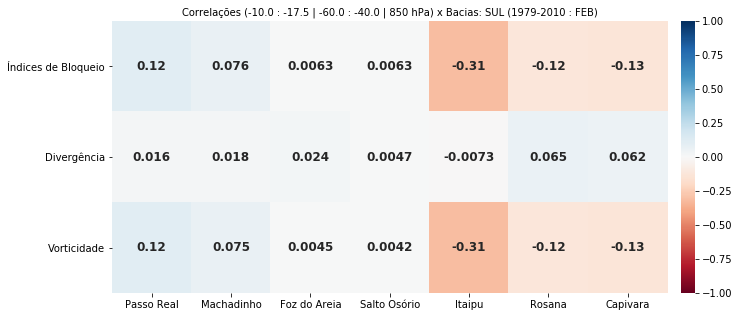

<Figure size 864x360 with 0 Axes>

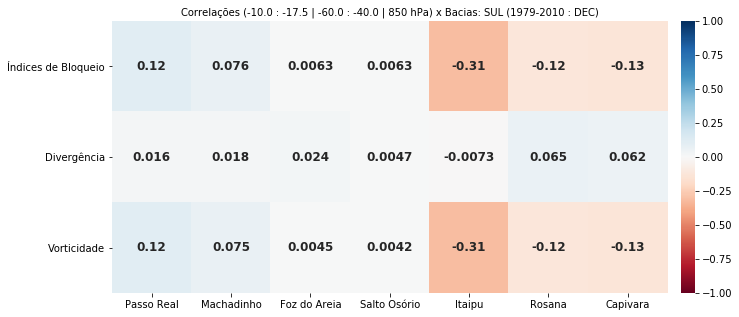

<Figure size 864x360 with 0 Axes>

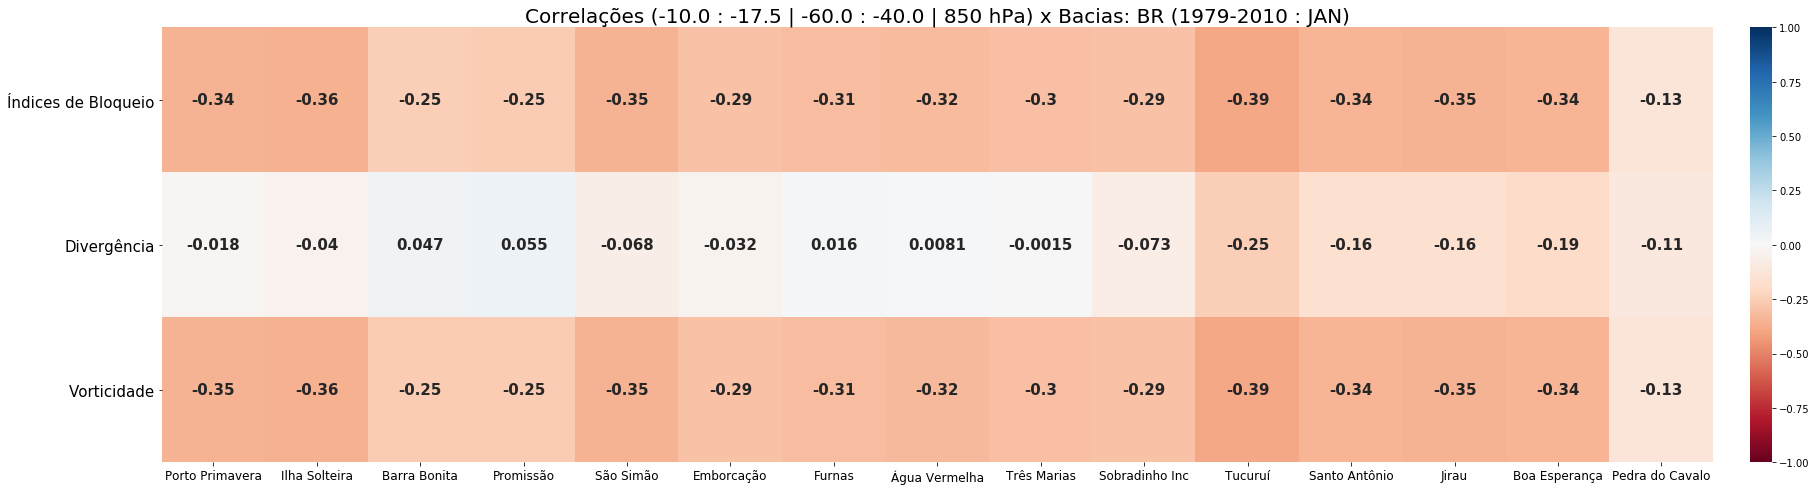

<Figure size 864x360 with 0 Axes>

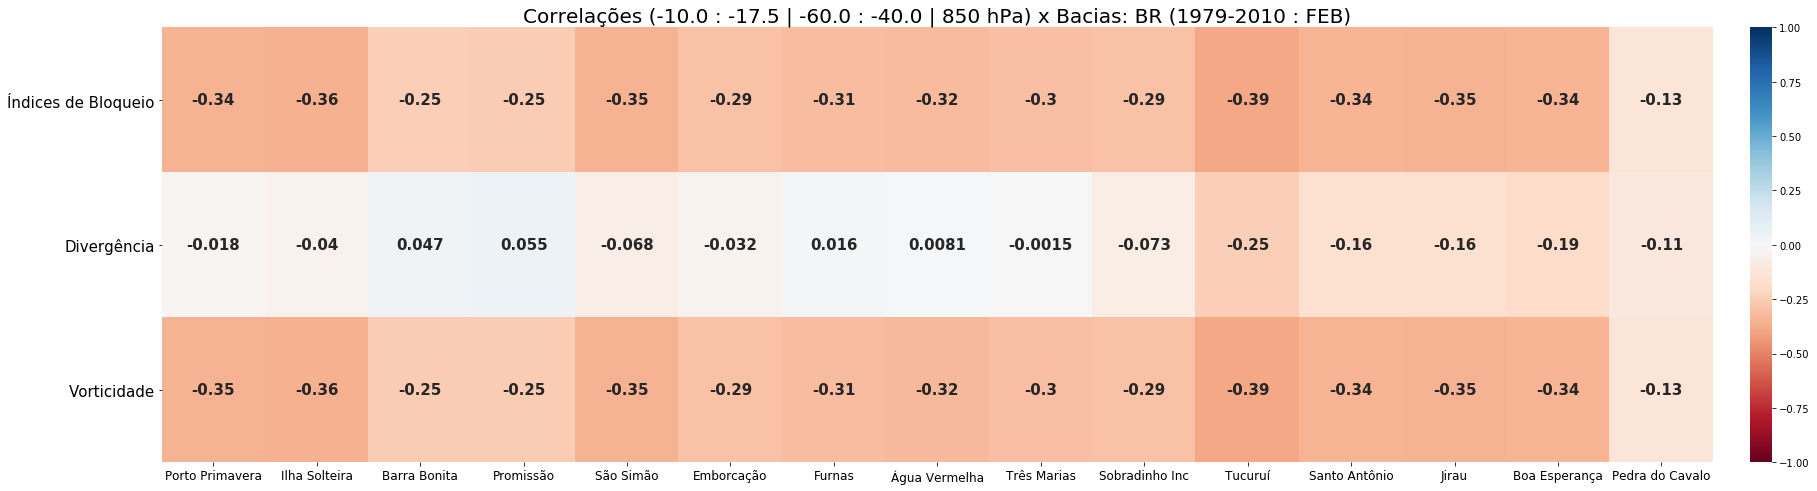

<Figure size 864x360 with 0 Axes>

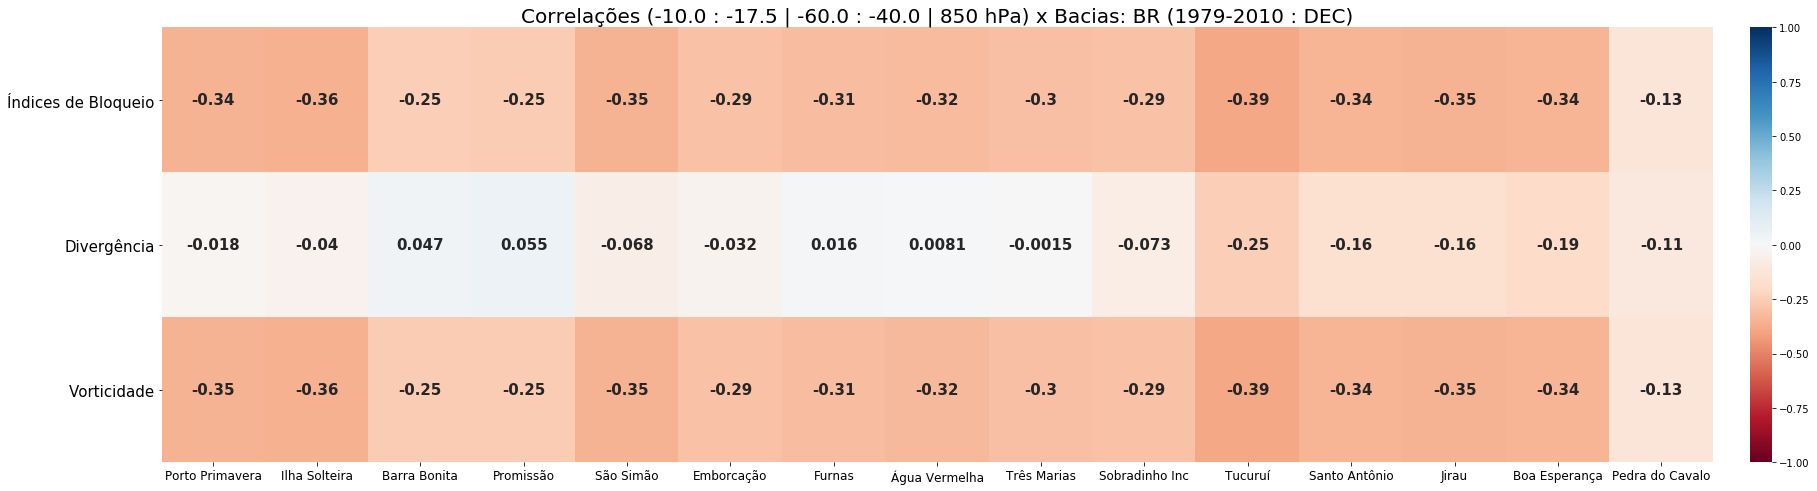

<Figure size 864x360 with 0 Axes>

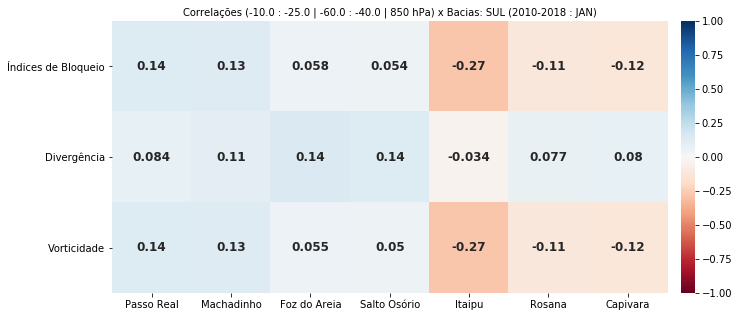

<Figure size 864x360 with 0 Axes>

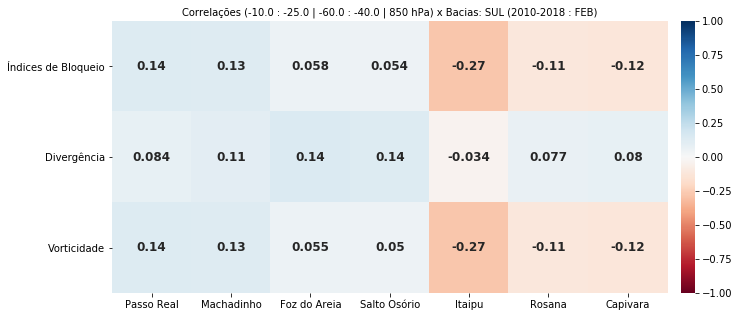

<Figure size 864x360 with 0 Axes>

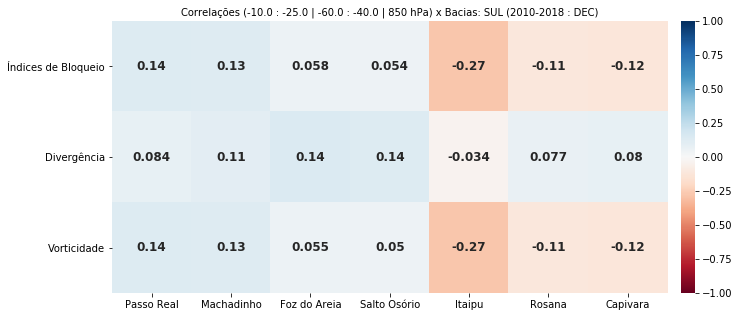

<Figure size 864x360 with 0 Axes>

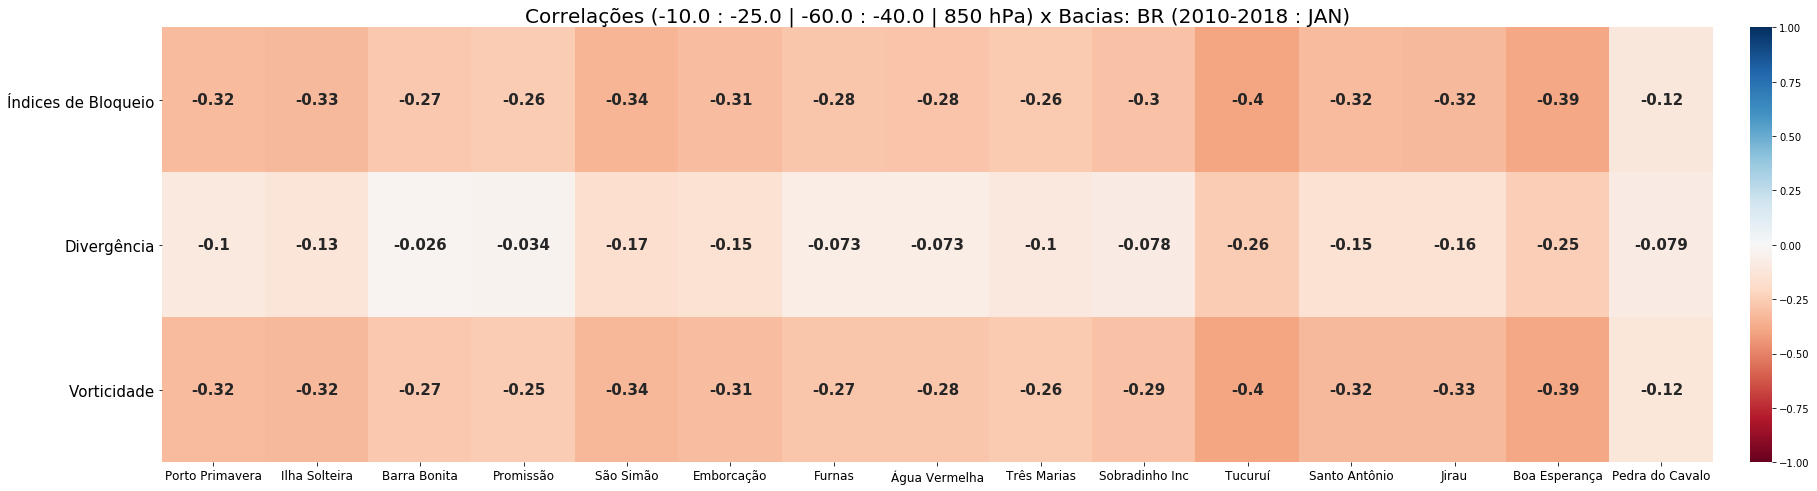

<Figure size 864x360 with 0 Axes>

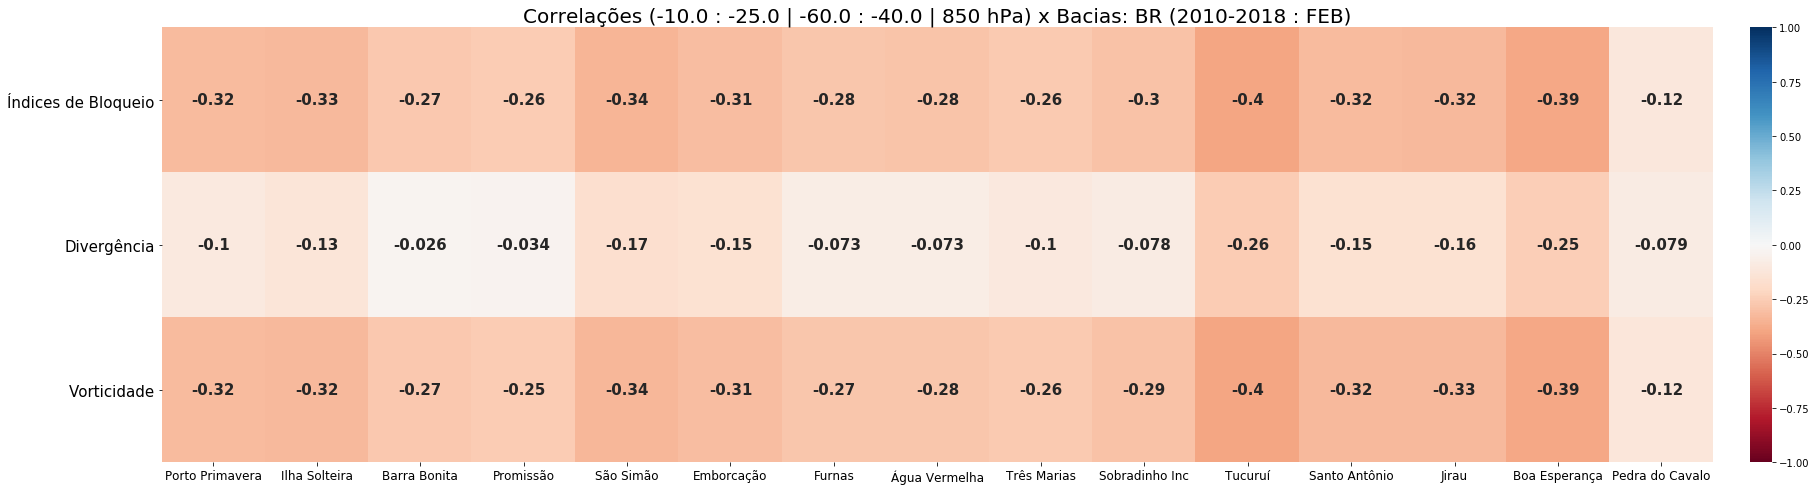

<Figure size 864x360 with 0 Axes>

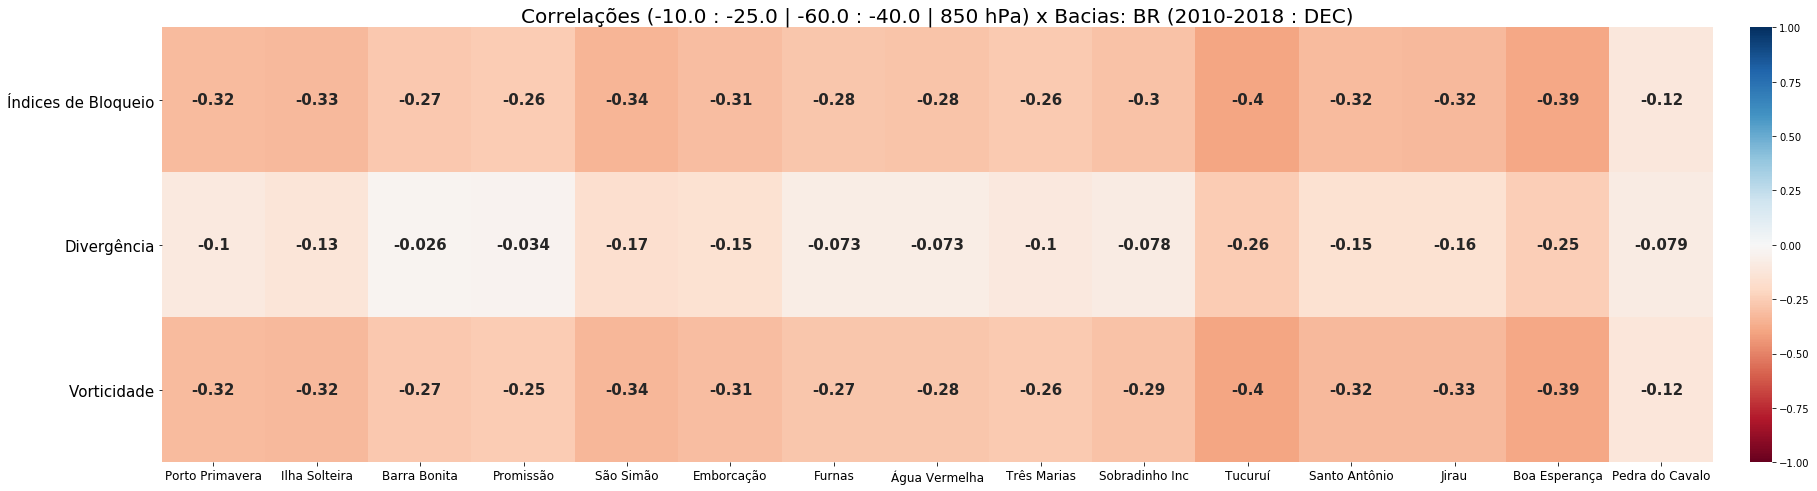

<Figure size 864x360 with 0 Axes>

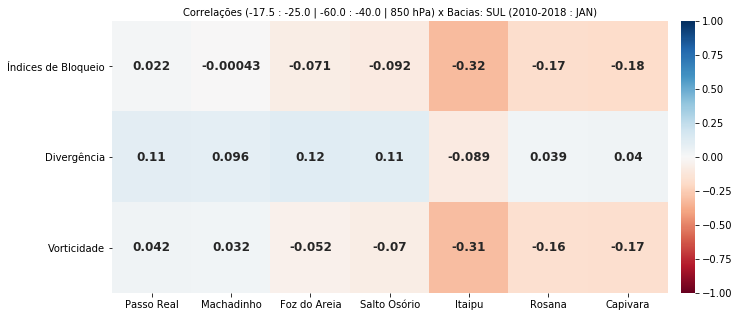

<Figure size 864x360 with 0 Axes>

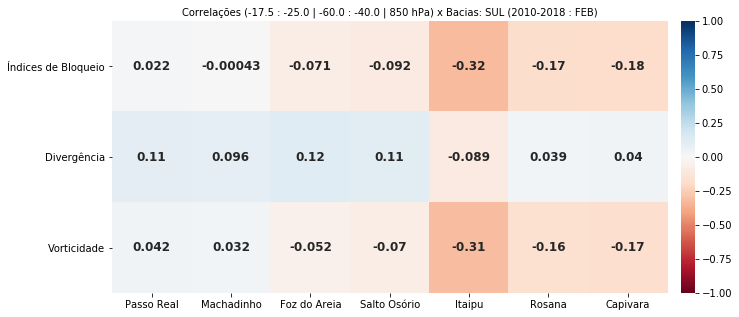

<Figure size 864x360 with 0 Axes>

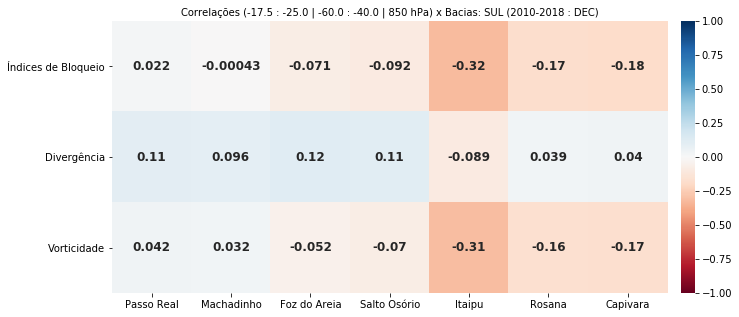

<Figure size 864x360 with 0 Axes>

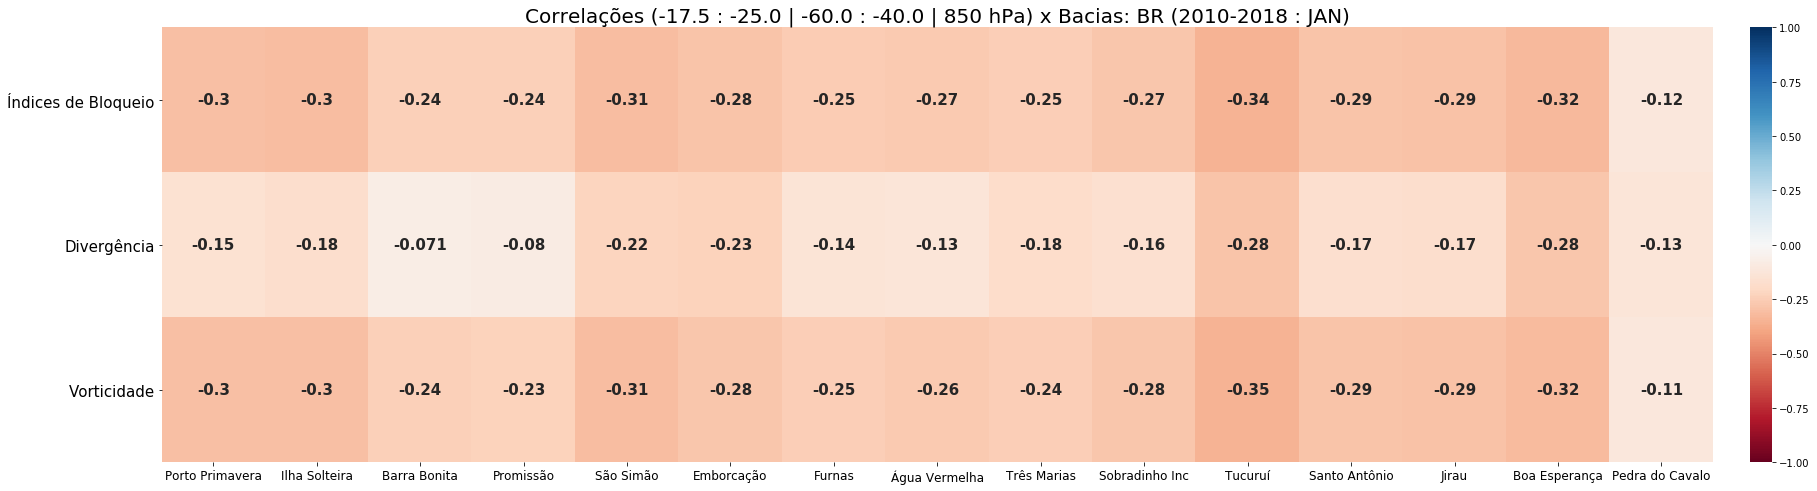

<Figure size 864x360 with 0 Axes>

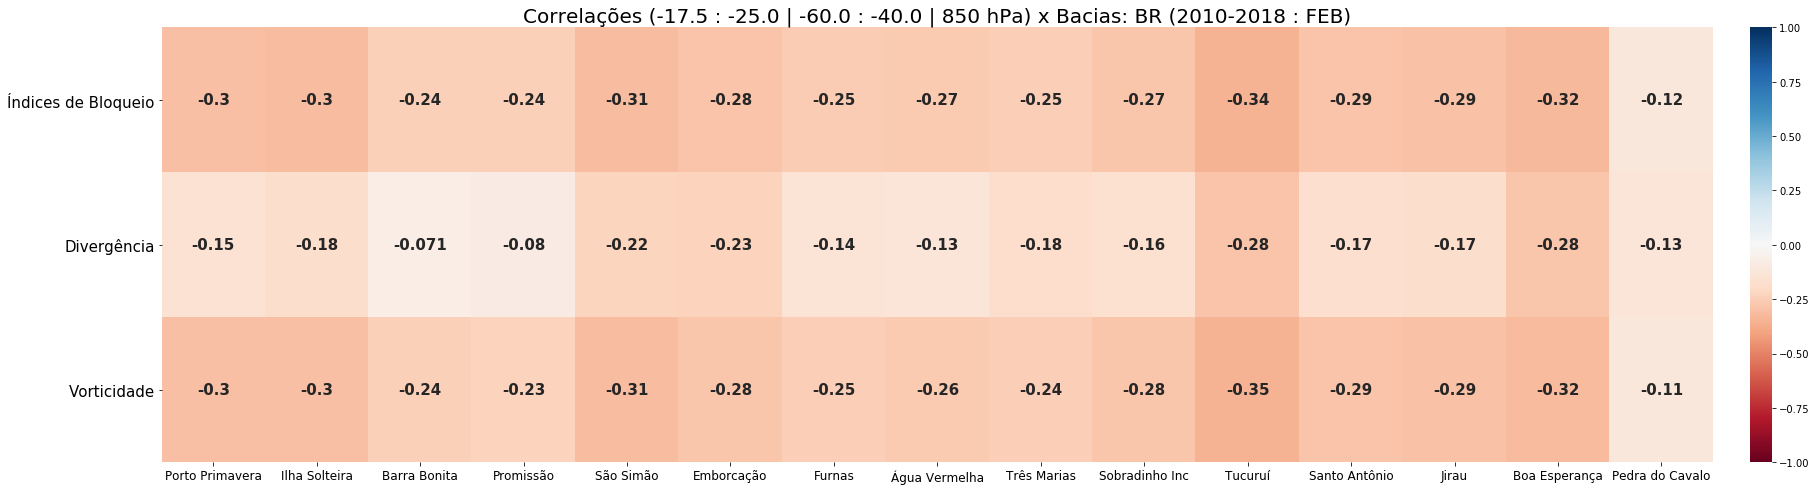

<Figure size 864x360 with 0 Axes>

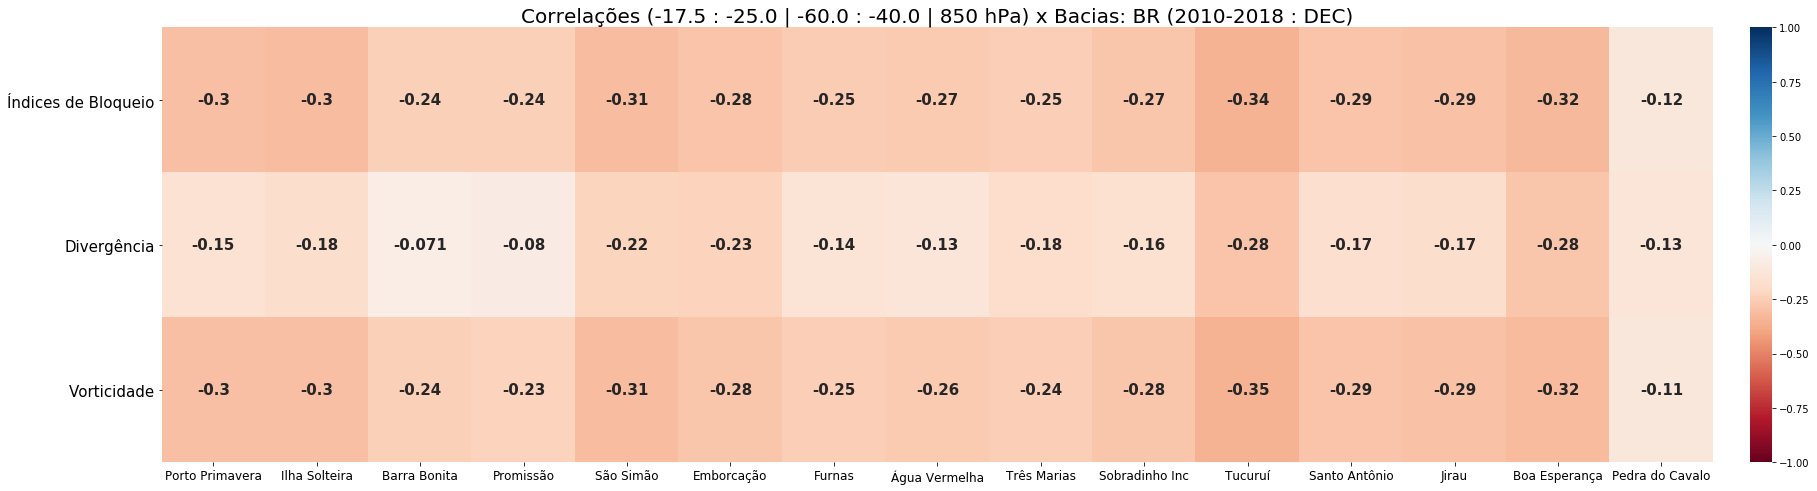

<Figure size 864x360 with 0 Axes>

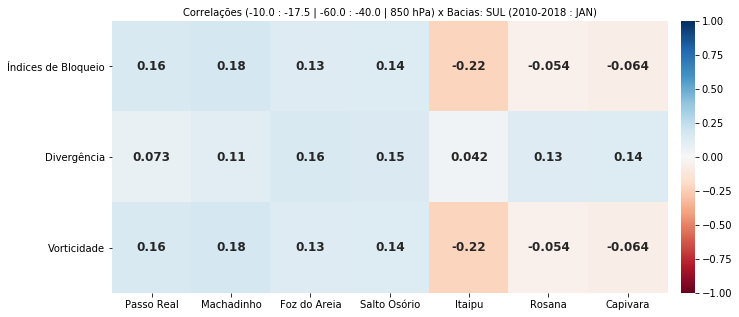

<Figure size 864x360 with 0 Axes>

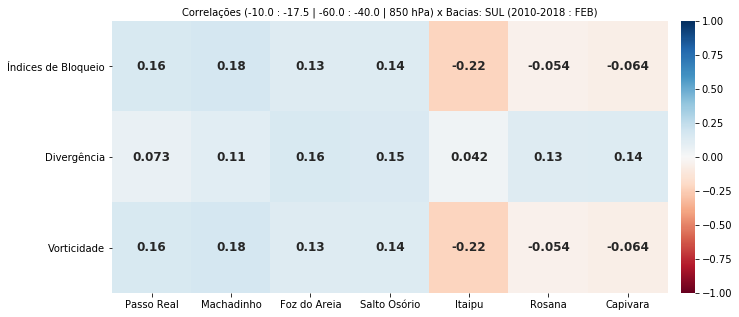

<Figure size 864x360 with 0 Axes>

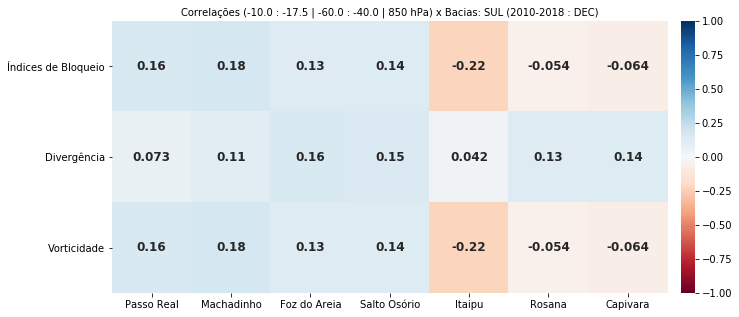

<Figure size 864x360 with 0 Axes>

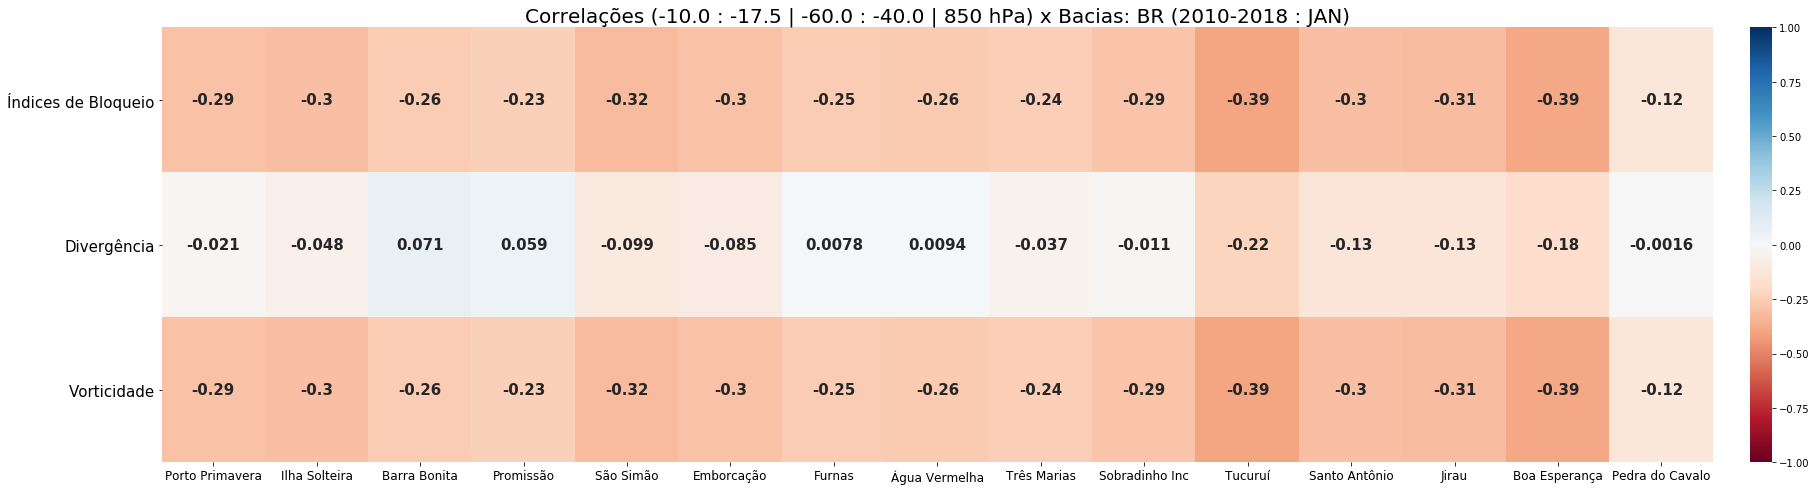

<Figure size 864x360 with 0 Axes>

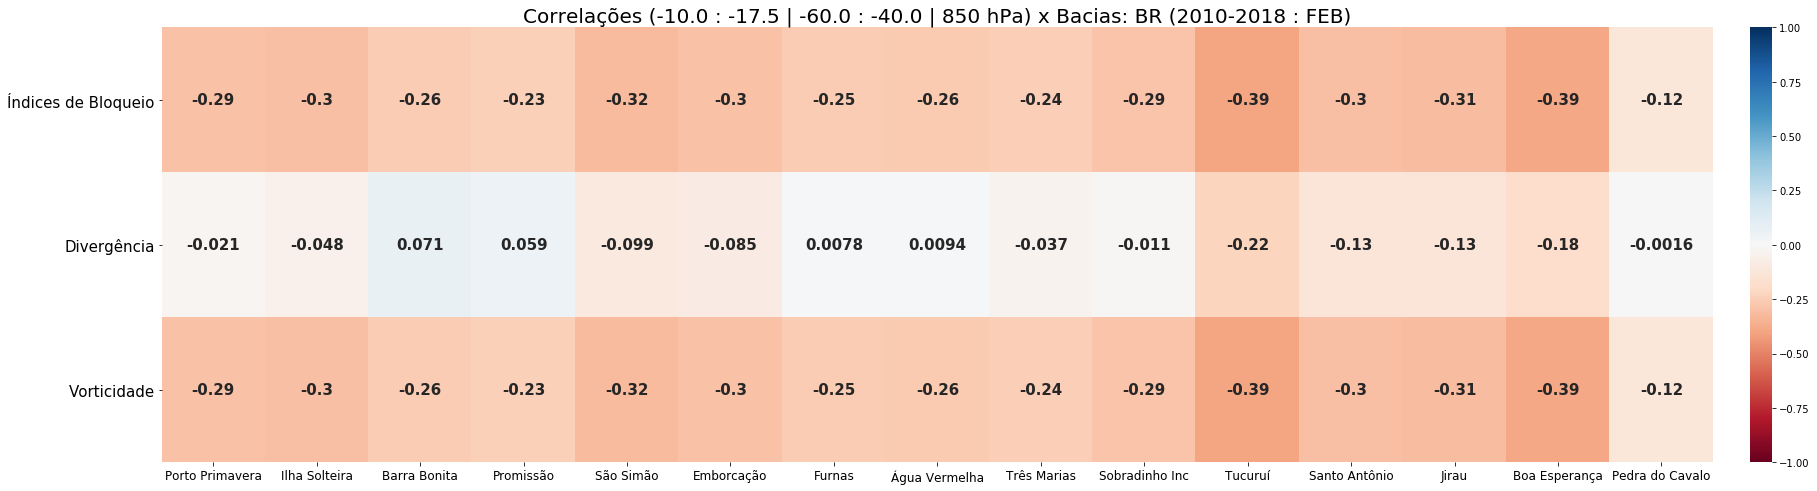

<Figure size 864x360 with 0 Axes>

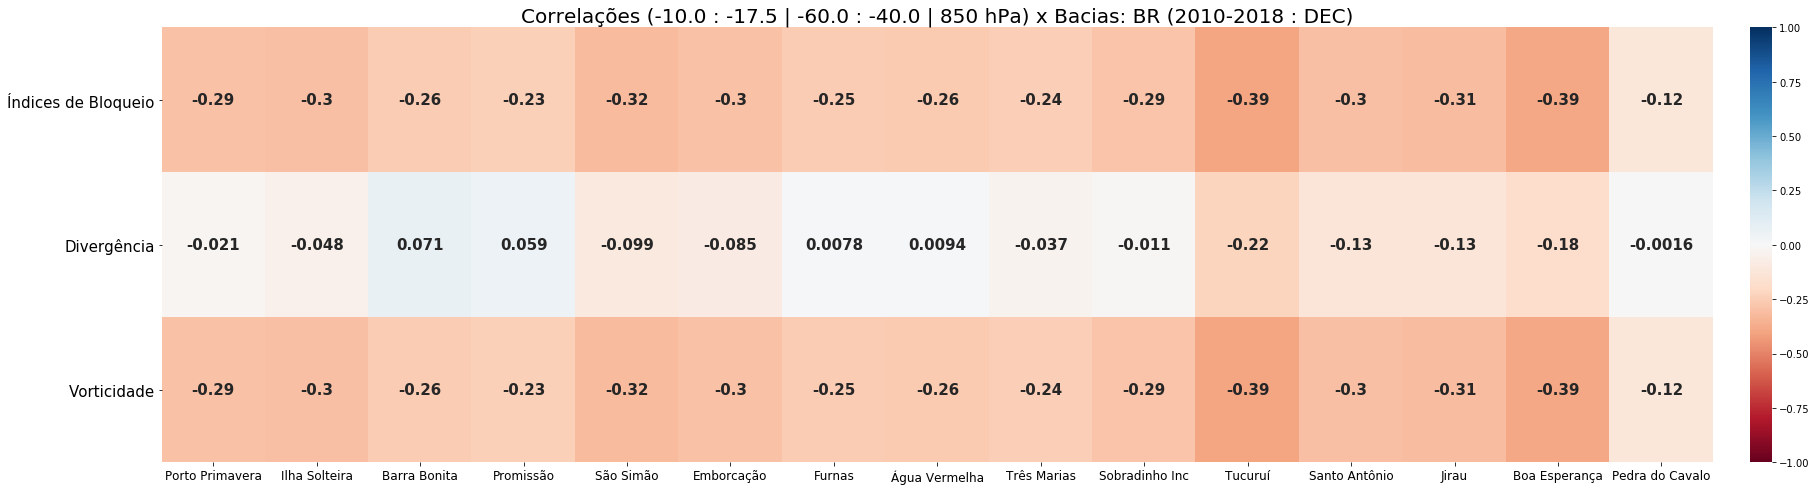

In [50]:
meses = [1, 2, 12]
regioes = ['sul' , 'br']
periodos = [['1979-01-01', '2010-12-31'], ['2010-01-01', '2018-12-31']]
latitudes = [[-10, -25], [-17.5, -25], [-10,-17.5]]
for periodo in periodos:
    for latitude in latitudes:
        div = dayly_obj.formatar(lat = latitude, lon = [-60, -40], time = periodo, level=850, opr='divergência')
        vort = dayly_obj.formatar(lat = latitude, lon = [-60, -40], time = periodo, level=850, opr='vorticidade')
        for regiao in regioes:
            for mes in meses:
                df = vazcorrs(atmds=[vort, div], regiao=regiao, groupby='month', bloq='total', freq='M', season=None, mes=mes, savefig=True, save_csv=True)